# Практическая работа к уроку №4



*   Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) сверточной сетью (самописной)
*   Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50
*   Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50 с аугментацией (самописной, с использованием Pytorch встроенных методов)






In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms, models
from torch import nn

In [2]:
!nvidia-smi

Thu Apr  7 21:37:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Обучение самописной сверточной сетью

### Загрузка датасета

In [3]:
batch_size = 1024

transform = transforms.Compose([
                                transforms.ToTensor(),
            ])

train_dataset = torchvision.datasets.CIFAR100(root='./data/', train=True,
                                              transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_dataset = torchvision.datasets.CIFAR100(root='./data/', train=False,
                                             transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

classes = train_dataset.classes
num_classes = len(train_dataset.classes)

print(f"len train dataset: {len(train_dataset)}")
print(f"len test dataset: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")

Files already downloaded and verified
Files already downloaded and verified
len train dataset: 50000
len test dataset: 10000
Number of classes: 100


In [4]:
def plot_batch(batch, normalize=False):
    images, labels = batch
    num_images = len(images)
    fig, axes = plt.subplots(4, 8, figsize=(15, 10))
    axes = axes.flatten()
    
    for ax, image, label in zip(axes, images, labels):
        ax.axis('off')

        inp = image.numpy().transpose((1, 2, 0))
        if normalize:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
        ax.imshow(inp)
        ax.set_title(classes[label.numpy()])

    plt.show()

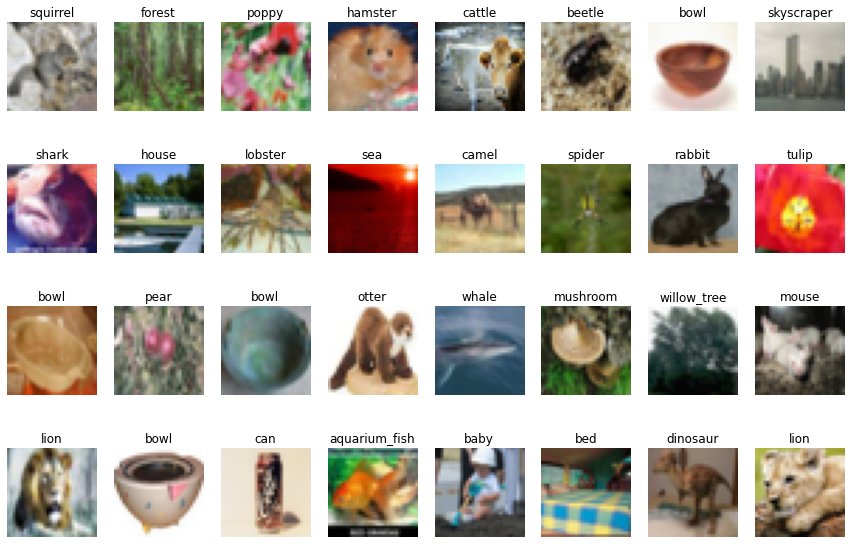

In [5]:
batch = next(iter(train_loader))
plot_batch(batch)

### Архитектура

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.conv2_1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.dp1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dp2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 100)
    
    def forward(self, x):
        # 32x32
        x1 = self.conv1_1(x)
        x2 = self.conv1_2(x)
        x = torch.cat((x1, x2), 1)
        x = self.pool1(x)
        # 16x16
        x1 = self.conv2_1(x)
        x2 = self.conv2_2(x)
        x = torch.cat((x1, x2), 1)
        x = self.pool2(x)
        # 8x8
        x = self.conv3(x)
        x = self.pool3(x)
        # 4x4
        x = x.view(-1, 256 * 4 * 4)
        x = self.dp1(F.relu(self.fc1(x)))
        x = self.dp2(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [7]:
model = Net()
model

Net(
  (conv1_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1_2): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(ke

In [8]:
from torchsummary import summary
batch = next(iter(train_loader))
summary(model, batch[0].shape[1:], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           2,432
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         204,928
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 25

### Обучение

In [9]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.set_grad_enabled(True):
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
        processed_data += inputs.size(0)

    loss = running_loss / processed_data
    acc = running_corrects.cpu().numpy() / processed_data

    return loss, acc

def test_epoch(model, dataloader, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
        processed_data += inputs.size(0)

    loss = running_loss / processed_data
    acc = running_corrects.cpu().numpy() / processed_data

    return loss, acc

def train(model, train_loader, test_loader, criterion, optimizer, epochs):
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': []
    }
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(
    #     optimizer, milestones=[10, 20], gamma=0.5, verbose=True)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        test_loss, test_acc = test_epoch(model, test_loader, criterion)
        # scheduler.step()

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f"train_loss: {train_loss}; train_acc: {train_acc}; test_loss: {test_loss}; test_acc: {test_acc}")
    
    return history

def predict(model, dataloader):
    model.eval()
    running_corrects, processed_data = 0, 0
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
        running_corrects += torch.sum(preds == labels)
        processed_data += inputs.size(0)
    acc = running_corrects.cpu().numpy() / processed_data

    return acc

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net()
model = model.to(DEVICE)

epochs = 40

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = {}
history['MyNet'] = {}
history['MyNet']['logs'] = train(model, train_loader, test_loader,
                                 criterion, optimizer, epochs)
history['MyNet']['train_accuracy'] = predict(model, train_loader)
history['MyNet']['test_accuracy'] = predict(model, test_loader)

  2%|▎         | 1/40 [00:17<11:26, 17.60s/it]

train_loss: 4.261368784561157; train_acc: 0.0501; test_loss: 3.9488653804779053; test_acc: 0.0963


  5%|▌         | 2/40 [00:34<10:45, 16.99s/it]

train_loss: 3.7037635906982422; train_acc: 0.11972; test_loss: 3.3976745555877685; test_acc: 0.177


  8%|▊         | 3/40 [00:51<10:32, 17.08s/it]

train_loss: 3.3563084242248533; train_acc: 0.17782; test_loss: 3.0861269565582274; test_acc: 0.2384


 10%|█         | 4/40 [01:08<10:15, 17.10s/it]

train_loss: 3.0521294075012206; train_acc: 0.23126; test_loss: 2.868285743713379; test_acc: 0.2768


 12%|█▎        | 5/40 [01:27<10:21, 17.74s/it]

train_loss: 2.8287965532684325; train_acc: 0.27484; test_loss: 2.77251919593811; test_acc: 0.3025


 15%|█▌        | 6/40 [01:45<10:05, 17.81s/it]

train_loss: 2.6505108891296385; train_acc: 0.31126; test_loss: 2.4797824054718016; test_acc: 0.3588


 18%|█▊        | 7/40 [02:03<09:48, 17.85s/it]

train_loss: 2.525693041534424; train_acc: 0.3343; test_loss: 2.78927142868042; test_acc: 0.3051


 20%|██        | 8/40 [02:21<09:38, 18.08s/it]

train_loss: 2.39230395652771; train_acc: 0.36716; test_loss: 2.3110628189086913; test_acc: 0.3947


 22%|██▎       | 9/40 [02:39<09:13, 17.86s/it]

train_loss: 2.2858012684631346; train_acc: 0.38726; test_loss: 2.239878313064575; test_acc: 0.4073


 25%|██▌       | 10/40 [02:56<08:53, 17.79s/it]

train_loss: 2.188742691421509; train_acc: 0.4054; test_loss: 2.088640896987915; test_acc: 0.4377


 28%|██▊       | 11/40 [03:14<08:34, 17.73s/it]

train_loss: 2.1064488291168213; train_acc: 0.42774; test_loss: 2.133778813934326; test_acc: 0.437


 30%|███       | 12/40 [03:31<08:10, 17.51s/it]

train_loss: 2.0278794877624513; train_acc: 0.4442; test_loss: 2.2192558795928954; test_acc: 0.4147


 32%|███▎      | 13/40 [03:48<07:46, 17.28s/it]

train_loss: 1.9489333866882323; train_acc: 0.46408; test_loss: 2.1227874435424803; test_acc: 0.4437


 35%|███▌      | 14/40 [04:05<07:27, 17.21s/it]

train_loss: 1.8971497841644287; train_acc: 0.4735; test_loss: 2.031554592514038; test_acc: 0.4597


 38%|███▊      | 15/40 [04:22<07:08, 17.14s/it]

train_loss: 1.8282522160339356; train_acc: 0.48756; test_loss: 2.1281684352874755; test_acc: 0.4489


 40%|████      | 16/40 [04:39<06:51, 17.15s/it]

train_loss: 1.7526224980926515; train_acc: 0.50316; test_loss: 2.1497743938446043; test_acc: 0.4455


 42%|████▎     | 17/40 [04:56<06:33, 17.11s/it]

train_loss: 1.7024893020248413; train_acc: 0.51508; test_loss: 1.9881703081130981; test_acc: 0.468


 45%|████▌     | 18/40 [05:16<06:37, 18.07s/it]

train_loss: 1.6348637866210938; train_acc: 0.52994; test_loss: 2.064433780670166; test_acc: 0.4612


 48%|████▊     | 19/40 [05:36<06:28, 18.51s/it]

train_loss: 1.5695902200698852; train_acc: 0.54528; test_loss: 2.2879835483551028; test_acc: 0.4432


 50%|█████     | 20/40 [05:53<06:01, 18.06s/it]

train_loss: 1.5254877850341797; train_acc: 0.55714; test_loss: 1.9410466346740722; test_acc: 0.4879


 52%|█████▎    | 21/40 [06:10<05:35, 17.68s/it]

train_loss: 1.4507764770126343; train_acc: 0.57392; test_loss: 1.9444407590866088; test_acc: 0.4913


 55%|█████▌    | 22/40 [06:26<05:13, 17.41s/it]

train_loss: 1.39678428981781; train_acc: 0.58664; test_loss: 2.0067865993499754; test_acc: 0.4882


 57%|█████▊    | 23/40 [06:43<04:54, 17.31s/it]

train_loss: 1.3419572798919677; train_acc: 0.59848; test_loss: 2.1478054790496826; test_acc: 0.4512


 60%|██████    | 24/40 [07:00<04:35, 17.21s/it]

train_loss: 1.2981138216400145; train_acc: 0.61026; test_loss: 2.191040177536011; test_acc: 0.4539


 62%|██████▎   | 25/40 [07:18<04:18, 17.21s/it]

train_loss: 1.2411465579605103; train_acc: 0.6264; test_loss: 2.0033000341415406; test_acc: 0.4903


 65%|██████▌   | 26/40 [07:35<04:00, 17.15s/it]

train_loss: 1.1821889651107789; train_acc: 0.639; test_loss: 2.026507124710083; test_acc: 0.4904


 68%|██████▊   | 27/40 [07:52<03:45, 17.31s/it]

train_loss: 1.1409757900619506; train_acc: 0.65096; test_loss: 1.8486175045013429; test_acc: 0.5174


 70%|███████   | 28/40 [08:11<03:32, 17.70s/it]

train_loss: 1.0849808516693116; train_acc: 0.66402; test_loss: 2.142734405517578; test_acc: 0.4764


 72%|███████▎  | 29/40 [08:30<03:19, 18.12s/it]

train_loss: 1.0457590050125123; train_acc: 0.67458; test_loss: 1.988207018470764; test_acc: 0.5122


 75%|███████▌  | 30/40 [08:48<03:00, 18.05s/it]

train_loss: 0.9941311677932739; train_acc: 0.6882; test_loss: 2.0880753997802732; test_acc: 0.494


 78%|███████▊  | 31/40 [09:06<02:42, 18.09s/it]

train_loss: 0.9493977079963684; train_acc: 0.70366; test_loss: 2.413386290740967; test_acc: 0.4455


 80%|████████  | 32/40 [09:29<02:35, 19.44s/it]

train_loss: 0.9308082421684265; train_acc: 0.70914; test_loss: 2.055243074226379; test_acc: 0.4955


 82%|████████▎ | 33/40 [09:47<02:13, 19.07s/it]

train_loss: 0.8872214291572571; train_acc: 0.71898; test_loss: 2.5038741191864013; test_acc: 0.4487


 85%|████████▌ | 34/40 [10:04<01:50, 18.45s/it]

train_loss: 0.845450679988861; train_acc: 0.73016; test_loss: 2.127602806091309; test_acc: 0.4994


 88%|████████▊ | 35/40 [10:21<01:29, 17.99s/it]

train_loss: 0.7944600962257385; train_acc: 0.74602; test_loss: 2.0713137031555178; test_acc: 0.5056


 90%|█████████ | 36/40 [10:38<01:10, 17.67s/it]

train_loss: 0.7702325782966614; train_acc: 0.7521; test_loss: 2.177051452255249; test_acc: 0.5093


 92%|█████████▎| 37/40 [10:55<00:52, 17.54s/it]

train_loss: 0.7294874393081665; train_acc: 0.76526; test_loss: 2.227324019241333; test_acc: 0.5013


 95%|█████████▌| 38/40 [11:12<00:34, 17.41s/it]

train_loss: 0.7072753421211243; train_acc: 0.76982; test_loss: 2.445756655883789; test_acc: 0.4897


 98%|█████████▊| 39/40 [11:29<00:17, 17.42s/it]

train_loss: 0.6744301294326782; train_acc: 0.77958; test_loss: 2.1612773525238036; test_acc: 0.5031


100%|██████████| 40/40 [11:47<00:00, 17.68s/it]


train_loss: 0.6435390786743164; train_acc: 0.7919; test_loss: 2.305898110961914; test_acc: 0.5015


100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


## Дообучение ImageNet Resnet-50

In [11]:
batch_size = 512

transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225]),
            ])

train_dataset = torchvision.datasets.CIFAR100(root='./data/', train=True,
                                              transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_dataset = torchvision.datasets.CIFAR100(root='./data/', train=False,
                                             transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

classes = train_dataset.classes
num_classes = len(train_dataset.classes)

print(f"len train dataset: {len(train_dataset)}")
print(f"len test dataset: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")

Files already downloaded and verified
Files already downloaded and verified
len train dataset: 50000
len test dataset: 10000
Number of classes: 100


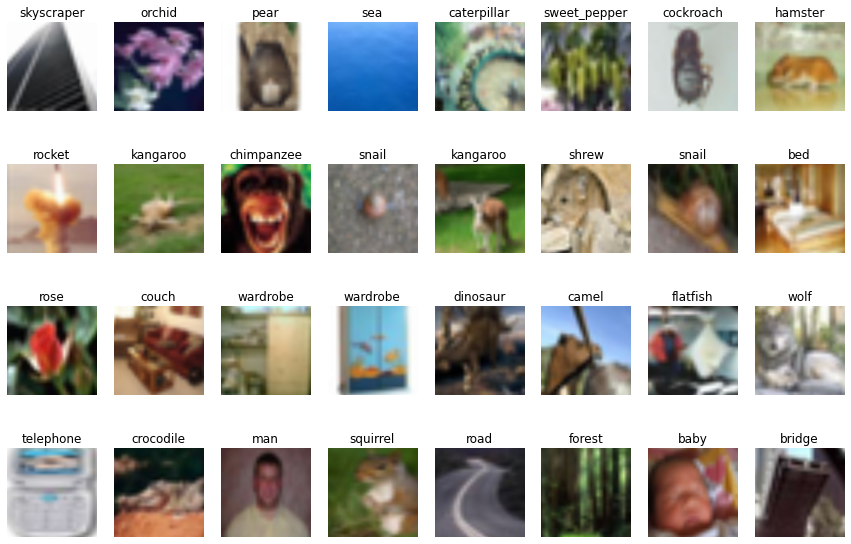

In [12]:
batch = next(iter(train_loader))
plot_batch(batch, normalize=True)

In [13]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False

def get_params_to_update(model):
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return params_to_update

In [14]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet50 = models.resnet50(pretrained=True)
set_parameter_requires_grad(resnet50)
resnet50.fc = nn.Linear(2048, 100)

resnet50 = resnet50.to(DEVICE)

epochs = 6

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(get_params_to_update(resnet50), lr=0.001)

history['resnet50'] = {}
history['resnet50']['logs'] = train(resnet50, train_loader, test_loader,
                                    criterion, optimizer, epochs)
history['resnet50']['train_accuracy'] = predict(resnet50, train_loader)
history['resnet50']['test_accuracy'] = predict(resnet50, test_loader)

 17%|█▋        | 1/6 [05:27<27:17, 327.48s/it]

train_loss: 2.9050488321685792; train_acc: 0.35688; test_loss: 2.1154804039001465; test_acc: 0.4763


 33%|███▎      | 2/6 [10:55<21:51, 327.78s/it]

train_loss: 1.9041191566848754; train_acc: 0.5121; test_loss: 1.8240127933502197; test_acc: 0.5243


 50%|█████     | 3/6 [16:22<16:21, 327.33s/it]

train_loss: 1.7043769161224365; train_acc: 0.5472; test_loss: 1.7178576297760009; test_acc: 0.5414


 67%|██████▋   | 4/6 [21:41<10:48, 324.21s/it]

train_loss: 1.6079023581314087; train_acc: 0.5686; test_loss: 1.6564297286987304; test_acc: 0.5501


 83%|████████▎ | 5/6 [26:59<05:21, 321.82s/it]

train_loss: 1.5466680715179444; train_acc: 0.58024; test_loss: 1.6119198091506959; test_acc: 0.5592


100%|██████████| 6/6 [32:15<00:00, 322.66s/it]


train_loss: 1.4976216402816773; train_acc: 0.58844; test_loss: 1.5823790176391601; test_acc: 0.5617


100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


## Дообучение ImageNet Resnet-50 с аугментацией

In [15]:
batch_size = 512

train_transform = transforms.Compose([
                                transforms.RandomRotation(degrees=15),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225]),
            ])
test_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225]),
            ])

train_dataset = torchvision.datasets.CIFAR100(root='./data/', train=True,
                                              transform=train_transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_dataset = torchvision.datasets.CIFAR100(root='./data/', train=False,
                                             transform=test_transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

classes = train_dataset.classes
num_classes = len(train_dataset.classes)

print(f"len train dataset: {len(train_dataset)}")
print(f"len test dataset: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")

Files already downloaded and verified
Files already downloaded and verified
len train dataset: 50000
len test dataset: 10000
Number of classes: 100


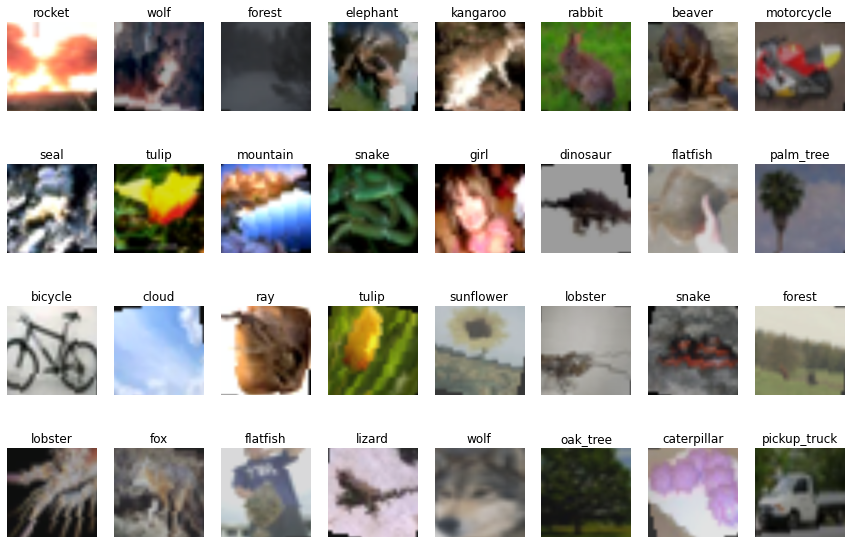

In [16]:
batch = next(iter(train_loader))
plot_batch(batch, normalize=True)

In [17]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet50_aug = models.resnet50(pretrained=True)
set_parameter_requires_grad(resnet50_aug)
resnet50_aug.fc = nn.Linear(2048, 100)

resnet50_aug = resnet50_aug.to(DEVICE)

epochs = 6

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(get_params_to_update(resnet50_aug), lr=0.001)

history['resnet50_aug'] = {}
history['resnet50_aug']['logs'] = train(resnet50_aug, train_loader, test_loader,
                                        criterion, optimizer, epochs)
history['resnet50_aug']['train_accuracy'] = predict(resnet50_aug, train_loader)
history['resnet50_aug']['test_accuracy'] = predict(resnet50_aug, test_loader)

 17%|█▋        | 1/6 [05:37<28:07, 337.59s/it]

train_loss: 3.3607270642089846; train_acc: 0.2504; test_loss: 2.3309937397003173; test_acc: 0.4375


 33%|███▎      | 2/6 [11:14<22:29, 337.29s/it]

train_loss: 2.5226205166625975; train_acc: 0.3795; test_loss: 2.0285005409240724; test_acc: 0.4811


 50%|█████     | 3/6 [16:50<16:50, 336.72s/it]

train_loss: 2.311212774581909; train_acc: 0.41304; test_loss: 1.8683888168334961; test_acc: 0.5113


 67%|██████▋   | 4/6 [22:26<11:12, 336.46s/it]

train_loss: 2.2187323832702637; train_acc: 0.42692; test_loss: 1.803939316558838; test_acc: 0.5207


 83%|████████▎ | 5/6 [28:03<05:36, 336.52s/it]

train_loss: 2.155918003387451; train_acc: 0.4395; test_loss: 1.7531260473251342; test_acc: 0.5275


100%|██████████| 6/6 [33:40<00:00, 336.75s/it]


train_loss: 2.113301139755249; train_acc: 0.44786; test_loss: 1.743167589378357; test_acc: 0.53


100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


## Сравнение результатов

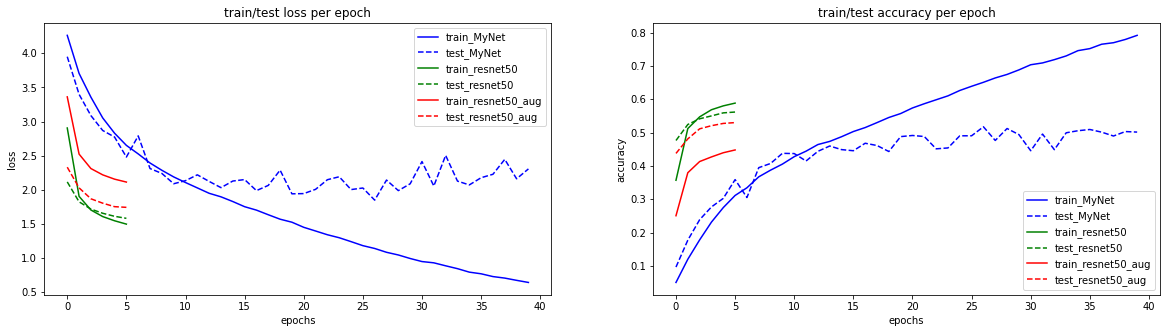

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

colors = ['b', 'g', 'r']

for (modelname, items), color in zip(history.items(), colors):
    ax1.plot(items['logs']['train_loss'], label=f"train_{modelname}", ls='-', c=color)
    ax1.plot(items['logs']['test_loss'], label=f"test_{modelname}", ls='--', c=color)

    ax2.plot(items['logs']['train_acc'], label=f"train_{modelname}", ls='-', c=color)
    ax2.plot(items['logs']['test_acc'], label=f"test_{modelname}", ls='--', c=color)

ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.title.set_text('train/test loss per epoch')

ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.title.set_text('train/test accuracy per epoch')

ax1.legend()
ax2.legend()
plt.show()

In [29]:
import pandas as pd


df_results = pd.DataFrame.from_dict(history, orient='index',
                                    columns=['train_accuracy', 'test_accuracy'])\
                .sort_values(by='test_accuracy', ascending=False)
df_results

,train_accuracy,test_accuracy
resnet50,0.60212,0.5611
resnet50_aug,0.45436,0.5338
MyNet,0.89176,0.5015


Собственная сеть очень сильно переобучилась, но показала близкий результат на тестовой выборке.

resnet50 без аугментаций лучше остальных, в том числе и resnet50 с аугментациями, но при более долгом обучении resnet50 с аугментациями показал бы более высокое accuracy, потому что на таком достаточно маленьком периоде обучения модель еще не успела приобрести хорошей обобщаещей способности для постоянно уникальных картинок.

При этом уже заметно, что resnet50 без аугментаций начинает постепенно переобучаться, поэтому в перспектике модель будет естественно хуже.